# Backward functions and the Backpropagation Algorithm

Here we will take a closer look at `Micrograd.jl`, which defines a way on how we can go backward automatically. Afterwards we will define a simple neuron and train it on a simple goal value as a simple motivation for the backpropagation algorithm.


In [1]:
import Pkg;
Pkg.activate("mymicrograd");
Pkg.add(path="https://github.com/ajloza/Micrograd.jl")

  Activating project at `~/Library/Mobile Documents/com~apple~CloudDocs/Projects/backprop-introduction/mymicrograd`
    Updating git-repo `https://github.com/ajloza/Micrograd.jl`
   Resolving package versions...
    Updating `~/Library/Mobile Documents/com~apple~CloudDocs/Projects/backprop-introduction/mymicrograd/Project.toml`
  [0111ca09] + Micrograd v0.1.0 `https://github.com/ajloza/Micrograd.jl#main`
    Updating `~/Library/Mobile Documents/com~apple~CloudDocs/Projects/backprop-introduction/mymicrograd/Manifest.toml`
  [0111ca09] + Micrograd v0.1.0 `https://github.com/ajloza/Micrograd.jl#main`


In [2]:
import Pkg;
Pkg.activate("mymicrograd");
using Revise
using Micrograd
include("./src/display.jl")
import .DisplayGraph

  Activating project at `~/Library/Mobile Documents/com~apple~CloudDocs/Projects/backprop-introduction/mymicrograd`


In [3]:
a = value(2.0)
b = value(-3.0)
c = value(10.0)
f = value(-2.0)
e = a * b
d = e + c
L = d * f

@show L.data
@show L.grad
@show L.prev
@show L.op;

L.data = -8.0
L.grad = 0.0
L.prev = (4.0 (gr: 0.0, op: +), -2.0 (gr: 0.0, op:  ))
L.op = "*"


Using the backward function enables us to do one step in backpropagation. Where we compute the gradients of the variables which result in the value we call `bw()` on. For example if we call `L.bw()`we will compute the gradients of $d$ and $f$:

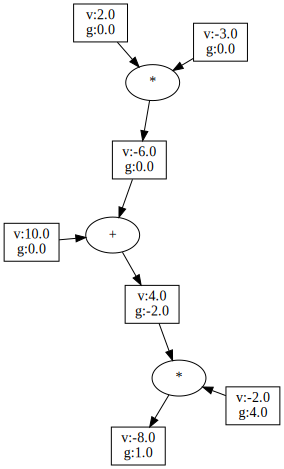

In [4]:
L.grad = 1.0
L.bw()
DisplayGraph.display_graph(L)

Afterwards we can call the backward function of $d$ to compute the next gradients. Note that we have to call the backward function of the top most variable first. In the case for $d$ we have to first call `L.bw()` and then `d.bw()`, since the gradients are used to compute the gradients of the next variable. 

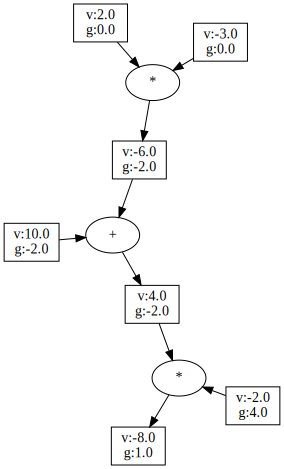

In [5]:
d.bw()
DisplayGraph.display_graph(L)

## Automating the process of computing the gradients:

We can use the package for Building a computational graph and going through it to compute the gradients: 

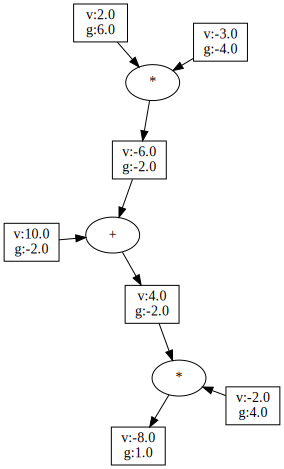

In [6]:
nodes, depth = buildgraph(L) # build the graph
zerograd(L) # gradients acumulate, need to reset them.
L.grad = 1.0 # set the gradient of the last node
for n in reverse(nodes) 
    n.bw() # backpropagate
end
DisplayGraph.display_graph(L)

# Example of a Single Neuron

In [59]:
## single neuron example, replicating micrograd example
x1 = value(2.0)
w1 = value(-3.0)
x2 = value(0.0)
w2 = value(1.0)
b = value(6.8813735870195432)

x1w1 = x1 * w1
x2w2 = x2 * w2

x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b
o = tanh(n)


println("Pre backpropagation:")
nodes, depth = buildgraph(o)
printgraph(nodes, depth)

println("\n\nPost backpropagation:")

backward(o)
printgraph(nodes, depth)

Pre backpropagation:

Tree:
----- 

0.71 (gr: 0.0, op: tanh)   
|
0.88 (gr: 0.0, op: +)   
|----------------------|
6.9 (gr: 0.0, op:  )   -6.0 (gr: 0.0, op: +)   
                       |---------------------------------------------|
                       0.0 (gr: 0.0, op: *)                          -6.0 (gr: 0.0, op: *)   
                       |----------------------|                      |-----------------------|
                       1.0 (gr: 0.0, op:  )   0.0 (gr: 0.0, op:  )   -3.0 (gr: 0.0, op:  )   2.0 (gr: 0.0, op:  )   

Post backpropagation:

Tree:
----- 

0.71 (gr: 1.0, op: tanh)   
|
0.88 (gr: 0.5, op: +)   
|----------------------|
6.9 (gr: 0.5, op:  )   -6.0 (gr: 0.5, op: +)   
                       |---------------------------------------------|
                       0.0 (gr: 0.5, op: *)                          -6.0 (gr: 0.5, op: *)   
                       |----------------------|                      |-----------------------|
                       1.0 (gr: 0

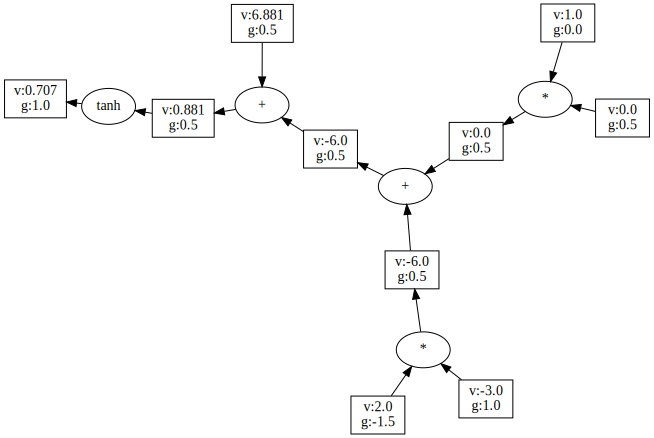

In [60]:
DisplayGraph.display_graph(o)

## Optimization 

A simple example for the optimization of this single neuron using the gradients derived using backpropagation. 
- At first we define a goal value which our neuron should output. Let's say $0.1$ for now. We can compute the difference to this goal using mean squared error (substracting our goal from the output and squaring it). 

In [61]:
goal = value(0.1)

0.1 (gr: 0.0, op:  )

- Next we calculate the gradients of the weights and the bias using the backpropagation algorithm starting at the last value - the Loss. 
- Then we can update the weights `w1`, `w2` and the bias `b` using the gradients by adding a small value using the negative gradient we estimated. 
- Then we calculate the output and the loss again. 
- We cam repeat this process until we reach our desired value. 

> - Note that we assume that we can only manipulate the weights and bias (similar to neural networks) where x is considered as input. 
> - If you want to try another goal you should note that we use a tanh method at the end and the output is restricted from -1 to +1. 
> - You can run the following cell multiple times to see how the output changes. It should get closer to the goal value.

In [62]:
println("Weights pre backpropagation:")
@show w1.data, w2.data, b.data;

L = (o - goal)^2 # mean squared error loss
@show L.data;

backward(L)
w1 += w1.grad * -0.1
w2 += w2.grad * -0.1
b += b.grad * -0.1

x1w1 = x1 * w1
x2w2 = x2 * w2

x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b
println("\n")
println("Output, loss and weights after backpropagation:")
@show o = tanh(n)
@show L = (o - goal)^2;

@show w1.data, w2.data, b.data;

Weights pre backpropagation:
(w1.data, w2.data, b.data) = (-3.0, 1.0, 6.881373587019543)
L.data = 0.36857864376269056


Output, loss and weights after backpropagation:
o = tanh(n) = -0.52 (gr: 0.0, op: tanh)
L = (o - goal) ^ 2 = 0.38 (gr: 0.0, op: ^)
(w1.data, w2.data, b.data) = (-3.6214213562373097, 1.0, 6.670662908900889)
